#### Friday, February 13, 2026

This all runs in one pass.

# Day Trading Deep Dive: From Zero to GPU-Accelerated Analysis

This notebook is your comprehensive guide to understanding day trading and building
an AI-assisted trading research environment using your RTX 4090.

---

## Table of Contents

1. **What is Day Trading?** - Core concepts and terminology
2. **Market Data** - Fetching and understanding stock data
3. **Reading Charts** - Candlesticks, volume, and price action
4. **Technical Indicators** - The math behind trading signals
5. **Sentiment Analysis with HuggingFace** - NLP for market sentiment
6. **ML Price Prediction** - GPU-accelerated forecasting with PyTorch
7. **HuggingFace Models for Finance** - Pre-trained models you can use
8. **GPU Acceleration Roadmap** - Making the most of your RTX 4090
9. **Risk Management** - The most important topic
10. **Next Steps & Resources**

---
## 1. What is Day Trading?

**Day trading** means buying and selling financial instruments (stocks, options, futures, crypto)
within the **same trading day** -- all positions are closed before the market closes.

### Key Concepts

| Term | Meaning |
|------|--------|
| **Long** | Buying a stock expecting it to go UP |
| **Short** | Borrowing & selling a stock expecting it to go DOWN, then buying back cheaper |
| **Bid/Ask** | Bid = highest price buyers will pay; Ask = lowest price sellers will accept |
| **Spread** | Difference between bid and ask (your cost to enter a trade) |
| **Volume** | Number of shares traded -- high volume = more liquidity |
| **Volatility** | How much a price moves -- day traders NEED volatility |
| **Candlestick** | Visual representation of open/high/low/close for a time period |
| **Support** | Price level where a stock tends to stop falling |
| **Resistance** | Price level where a stock tends to stop rising |
| **Stop Loss** | Automatic sell order to limit losses |
| **Take Profit** | Automatic sell order to lock in gains |
| **PDT Rule** | Pattern Day Trader rule: need $25k+ to make 4+ day trades in 5 days (US) |

### What Day Traders Actually Do

1. **Pre-market (4am-9:30am ET)**: Scan for stocks with unusual volume, news catalysts, earnings
2. **Market open (9:30am-11:30am ET)**: Most volatile period -- where most trading happens
3. **Midday (11:30am-2pm ET)**: Usually slower, choppy price action
4. **Power hour (3pm-4pm ET)**: Volatility picks up again before close

### Common Day Trading Strategies

- **Momentum Trading**: Ride stocks making big moves on high volume
- **Scalping**: Many small trades for tiny profits (pennies to dimes per share)
- **Breakout Trading**: Enter when price breaks through support/resistance
- **Mean Reversion**: Bet that overextended moves will snap back
- **Gap Trading**: Trade stocks that gap up/down from previous close
- **VWAP Trading**: Trade around the Volume-Weighted Average Price

---
## 2. Market Data - Fetching Real Stock Data

We'll use `yfinance` to pull free historical data from Yahoo Finance.
This is great for learning and backtesting, though not suitable for live trading (delayed data).

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('dark_background')
sns.set_palette('bright')

print("All imports successful!")

All imports successful!


In [2]:
# Fetch data for some popular day-trading stocks
# These are large, liquid stocks that day traders frequently watch
tickers = ['AAPL', 'NVDA', 'TSLA', 'AMD', 'SPY']

# Get 6 months of daily data
data = {}
for ticker in tickers:
    df = yf.download(ticker, period='6mo', interval='1d', progress=False)
    # Flatten MultiIndex columns (yfinance returns MultiIndex even for single tickers)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    data[ticker] = df
    print(f"{ticker}: {len(df)} trading days, "
          f"Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

# Show what the data looks like
print("\n--- Sample data for NVDA ---")
data['NVDA'].tail()

AAPL: 127 trading days, Price range: $224.47 - $285.92
NVDA: 127 trading days, Price range: $167.00 - $207.03
TSLA: 127 trading days, Price range: $320.11 - $489.88
AMD: 127 trading days, Price range: $151.14 - $264.33
SPY: 127 trading days, Price range: $631.93 - $695.49

--- Sample data for NVDA ---


Price,Close,High,Low,Open,Volume
Date,,,,,
2026-02-09,190.039993,193.660004,183.949997,184.259995,196387400
2026-02-10,188.539993,192.479996,188.119995,191.380005,136764800
2026-02-11,190.050003,193.259995,188.770004,192.449997,144192700
2026-02-12,186.940002,193.610001,186.509995,193.029999,189932500
2026-02-13,182.809998,187.470001,181.589996,187.464996,161438894


In [3]:
# Get intraday data (what day traders actually look at)
# yfinance gives up to 60 days of intraday data
nvda_intraday = yf.download('NVDA', period='5d', interval='5m', progress=False)
print(f"Intraday data shape: {nvda_intraday.shape}")
print(f"Interval: 5-minute bars")
print(f"\nFirst few bars:")
nvda_intraday.head(10)

Intraday data shape: (390, 5)
Interval: 5-minute bars

First few bars:


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Datetime,,,,,
2026-02-09 14:30:00+00:00,187.300705,187.460007,184.000000,184.100006,11288325
2026-02-09 14:35:00+00:00,189.509903,189.509995,186.779999,187.300003,5278082
2026-02-09 14:40:00+00:00,190.919998,190.940002,189.000000,189.495102,5376033
2026-02-09 14:45:00+00:00,193.520004,193.660004,190.839996,190.914993,7480951
2026-02-09 14:50:00+00:00,191.500000,193.559998,191.255005,193.514999,4987947
2026-02-09 14:55:00+00:00,191.160004,191.729996,190.809998,191.520004,3664736
2026-02-09 15:00:00+00:00,190.880005,192.050003,190.729996,191.160004,2910879
2026-02-09 15:05:00+00:00,191.940094,192.380005,190.740005,190.869995,2972034


### Understanding OHLCV Data

Every bar/candle has 5 key data points:
- **Open**: Price at the start of the period
- **High**: Highest price during the period
- **Low**: Lowest price during the period
- **Close**: Price at the end of the period
- **Volume**: Number of shares traded during the period

---
## 3. Reading Charts - Candlesticks & Price Action

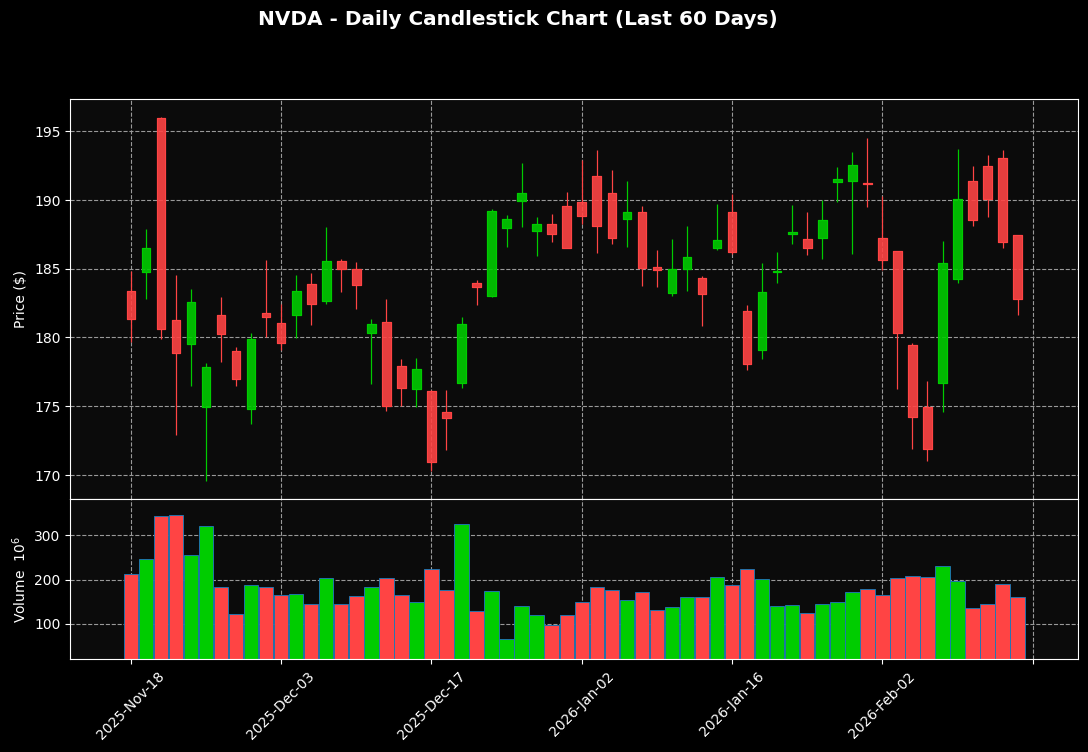

In [4]:
# Candlestick chart - This is what traders look at all day
# Green candle = Close > Open (price went up)
# Red candle = Close < Open (price went down)
# The "body" shows open-to-close range
# The "wicks" show the high and low

nvda_recent = data['NVDA'].tail(60)  # Last ~3 months

# Fix column names for mplfinance (flatten multi-index if present)
df_plot = nvda_recent.copy()
if isinstance(df_plot.columns, pd.MultiIndex):
    df_plot.columns = df_plot.columns.get_level_values(0)

# Custom market colors: green up, red down (standard trading convention)
mc = mpf.make_marketcolors(up='#00cc00', down='#ff4444',
                           edge='inherit',
                           wick='inherit',
                           volume='inherit')
chart_style = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc)

mpf.plot(
    df_plot,
    type='candle',
    style=chart_style,
    title='NVDA - Daily Candlestick Chart (Last 60 Days)',
    ylabel='Price ($)',
    volume=True,
    figsize=(14, 8),
    warn_too_much_data=200
)

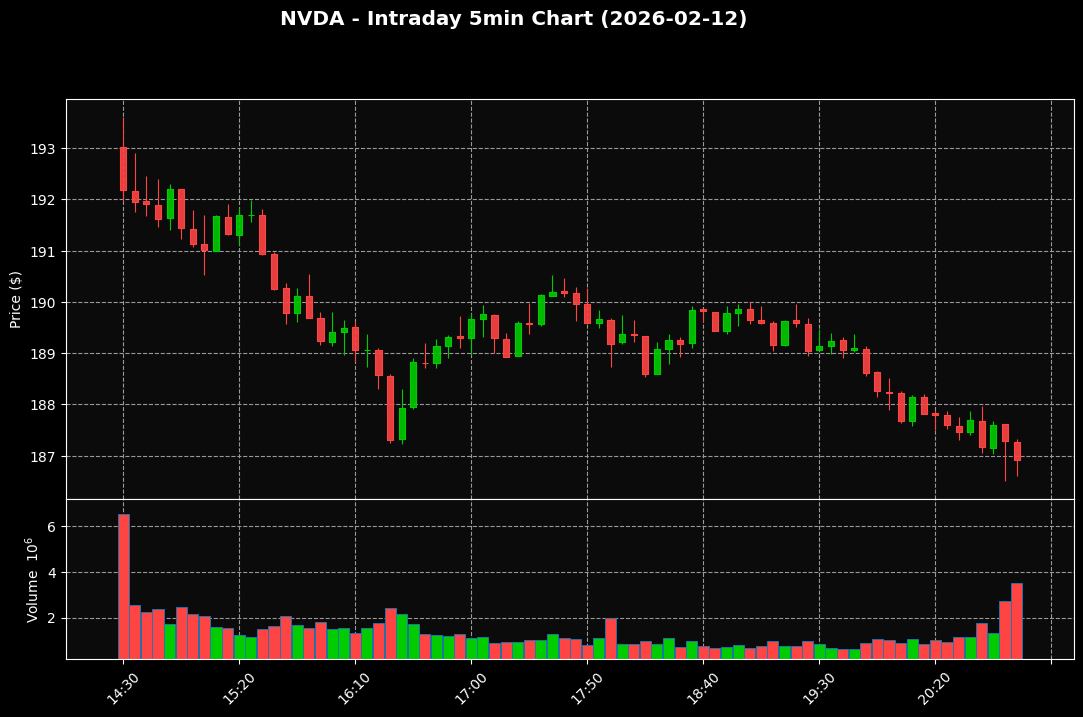

Day range: $186.51 - $193.60
Total volume: 107,461,471 shares


In [5]:
# Intraday chart - What a real day trading screen looks like
# Let's look at one day of 5-minute candles

df_intraday = nvda_intraday.copy()
if isinstance(df_intraday.columns, pd.MultiIndex):
    df_intraday.columns = df_intraday.columns.get_level_values(0)

# Get the most recent full trading day
dates = df_intraday.index.date
unique_dates = sorted(set(dates))
last_full_day = unique_dates[-2] if len(unique_dates) > 1 else unique_dates[-1]
one_day = df_intraday[df_intraday.index.date == last_full_day]

# Custom market colors: green up, red down (standard trading convention)
mc = mpf.make_marketcolors(up='#00cc00', down='#ff4444',
                           edge='inherit',
                           wick='inherit',
                           volume='inherit')
chart_style = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc)

mpf.plot(
    one_day,
    type='candle',
    style=chart_style,
    title=f'NVDA - Intraday 5min Chart ({last_full_day})',
    ylabel='Price ($)',
    volume=True,
    figsize=(14, 8),
    warn_too_much_data=200
)

print(f"Day range: ${one_day['Low'].min():.2f} - ${one_day['High'].max():.2f}")
print(f"Total volume: {one_day['Volume'].sum():,.0f} shares")

### Key Candlestick Patterns Day Traders Watch For

| Pattern | Shape | Meaning |
|---------|-------|---------|
| **Doji** | Tiny body, equal wicks | Indecision - possible reversal |
| **Hammer** | Small body at top, long lower wick | Bullish reversal (at support) |
| **Shooting Star** | Small body at bottom, long upper wick | Bearish reversal (at resistance) |
| **Engulfing** | Large candle that "engulfs" previous | Strong reversal signal |
| **Morning/Evening Star** | 3-candle reversal pattern | Trend reversal |

These patterns are most meaningful when they form at key support/resistance levels with high volume.

---
## 4. Technical Indicators - The Math Behind Trading Signals

Technical indicators are mathematical calculations based on price and volume.
Day traders use them to identify trends, momentum, and potential entry/exit points.

In [6]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice

# Work with NVDA daily data
df = data['NVDA'].copy()
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# ---- Moving Averages ----
# SMA (Simple Moving Average): average of last N prices
# EMA (Exponential Moving Average): weighted average, more responsive to recent prices
df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
df['EMA_9'] = EMAIndicator(df['Close'], window=9).ema_indicator()

# ---- RSI (Relative Strength Index) ----
# 0-100 scale. Above 70 = overbought (might drop), Below 30 = oversold (might rise)
df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()

# ---- MACD (Moving Average Convergence Divergence) ----
# Shows momentum and trend direction
macd = MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Histogram'] = macd.macd_diff()

# ---- Bollinger Bands ----
# Price channel based on standard deviations from moving average
bb = BollingerBands(df['Close'])
df['BB_Upper'] = bb.bollinger_hband()
df['BB_Lower'] = bb.bollinger_lband()
df['BB_Middle'] = bb.bollinger_mavg()

# ---- ATR (Average True Range) ----
# Measures volatility - useful for setting stop losses
df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()

print("Technical indicators calculated!")
df[['Close', 'SMA_20', 'EMA_9', 'RSI', 'MACD', 'ATR']].tail(10)

Technical indicators calculated!


Price,Close,SMA_20,EMA_9,RSI,MACD,ATR
Date,,,,,,
2026-02-02,185.610001,186.560001,188.101958,48.810323,1.207745,5.256091
2026-02-03,180.339996,186.171001,186.549566,42.340067,0.531727,5.597800
2026-02-04,174.190002,185.518501,184.077653,36.293761,-0.494573,5.800099
2026-02-05,171.880005,184.657001,181.638123,34.311763,-1.477292,5.799378
2026-02-06,185.410004,184.675501,182.392499,51.141641,-1.151077,6.465137
2026-02-09,190.039993,184.934501,183.921998,55.356815,-0.513034,6.696913
2026-02-10,188.539993,185.114500,184.845597,53.739241,-0.126954,6.529991
2026-02-11,190.050003,185.326501,185.886478,55.159719,0.297434,6.400706
2026-02-12,186.940002,185.516501,186.097183,51.642538,0.378450,6.450656


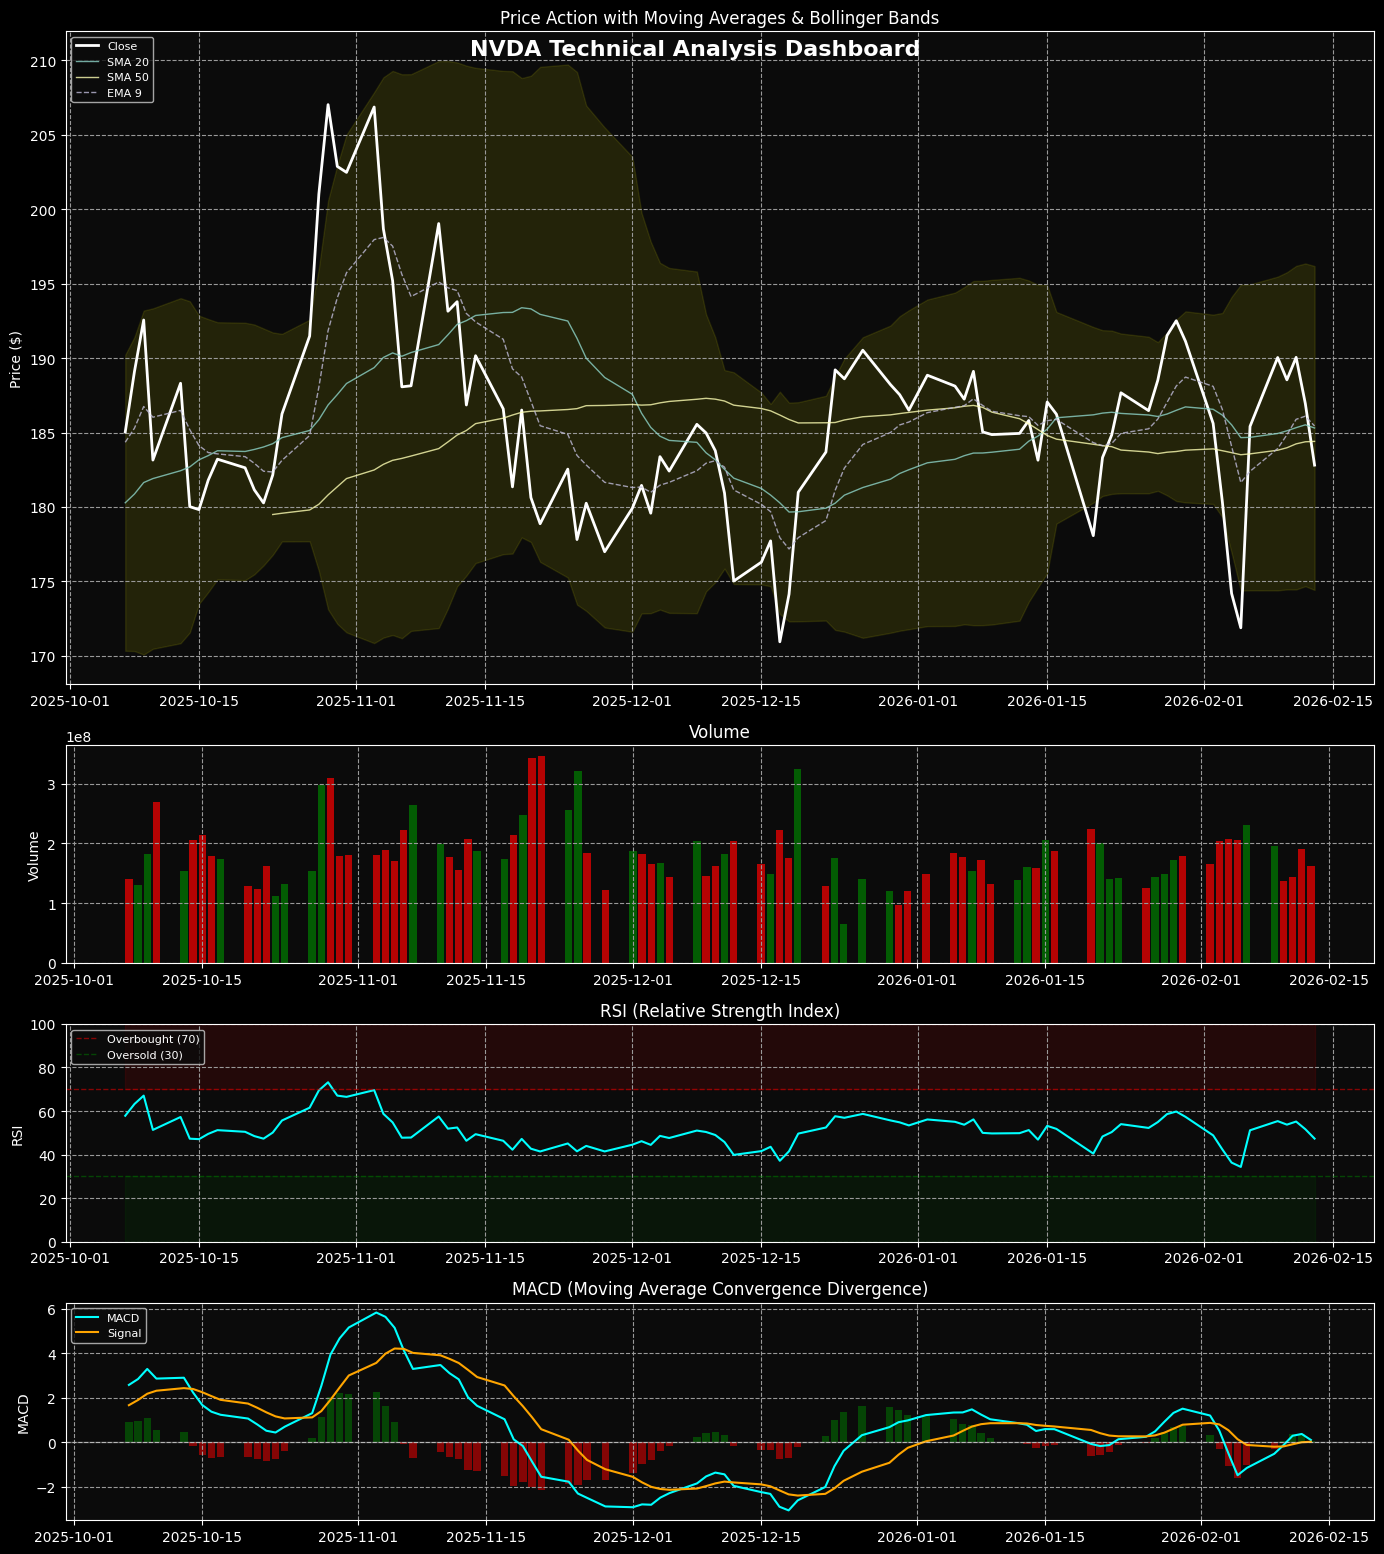


--- How to Read These ---
PRICE: When short-term MA crosses above long-term MA = bullish signal
RSI:   Above 70 = potentially overbought, Below 30 = potentially oversold
MACD:  When MACD crosses above Signal line = bullish momentum
VOLUME: High volume confirms price moves; low volume = weak/suspect moves


In [7]:
# Visualize the key indicators
fig, axes = plt.subplots(4, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
fig.suptitle('NVDA Technical Analysis Dashboard', fontsize=16, y=0.95)

recent = df.tail(90).copy()

# Price + Moving Averages + Bollinger Bands
ax1 = axes[0]
ax1.plot(recent.index, recent['Close'], label='Close', linewidth=2, color='white')
ax1.plot(recent.index, recent['SMA_20'], label='SMA 20', linewidth=1, alpha=0.8)
ax1.plot(recent.index, recent['SMA_50'], label='SMA 50', linewidth=1, alpha=0.8)
ax1.plot(recent.index, recent['EMA_9'], label='EMA 9', linewidth=1, alpha=0.8, linestyle='--')
ax1.fill_between(recent.index, recent['BB_Upper'], recent['BB_Lower'], alpha=0.1, color='yellow')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title('Price Action with Moving Averages & Bollinger Bands')

# Volume
ax2 = axes[1]
colors = ['green' if c >= o else 'red' for c, o in zip(recent['Close'], recent['Open'])]
ax2.bar(recent.index, recent['Volume'], color=colors, alpha=0.7)
ax2.set_ylabel('Volume')
ax2.set_title('Volume')

# RSI
ax3 = axes[2]
ax3.plot(recent.index, recent['RSI'], color='cyan', linewidth=1.5)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax3.fill_between(recent.index, 70, 100, alpha=0.1, color='red')
ax3.fill_between(recent.index, 0, 30, alpha=0.1, color='green')
ax3.set_ylabel('RSI')
ax3.set_ylim(0, 100)
ax3.legend(loc='upper left', fontsize=8)
ax3.set_title('RSI (Relative Strength Index)')

# MACD
ax4 = axes[3]
ax4.plot(recent.index, recent['MACD'], label='MACD', color='cyan', linewidth=1.5)
ax4.plot(recent.index, recent['MACD_Signal'], label='Signal', color='orange', linewidth=1.5)
macd_colors = ['green' if v >= 0 else 'red' for v in recent['MACD_Histogram']]
ax4.bar(recent.index, recent['MACD_Histogram'], color=macd_colors, alpha=0.5)
ax4.axhline(y=0, color='white', linestyle='-', alpha=0.3)
ax4.set_ylabel('MACD')
ax4.legend(loc='upper left', fontsize=8)
ax4.set_title('MACD (Moving Average Convergence Divergence)')

plt.tight_layout()
plt.show()

print("\n--- How to Read These ---")
print("PRICE: When short-term MA crosses above long-term MA = bullish signal")
print("RSI:   Above 70 = potentially overbought, Below 30 = potentially oversold")
print("MACD:  When MACD crosses above Signal line = bullish momentum")
print("VOLUME: High volume confirms price moves; low volume = weak/suspect moves")

### Key Indicators Summary for Day Traders

| Indicator | What it Shows | Day Trading Use |
|-----------|--------------|------------------|
| **VWAP** | Volume-weighted average price | #1 intraday indicator. Price above VWAP = bullish bias |
| **EMA 9/20** | Short-term trend | Quick trend direction on intraday charts |
| **RSI** | Overbought/oversold | Time entries/exits, divergence signals |
| **MACD** | Momentum & trend | Confirm trend direction and momentum shifts |
| **Bollinger Bands** | Volatility channel | Mean reversion entries at band extremes |
| **ATR** | Volatility measure | Set stop losses (e.g., 1.5x ATR from entry) |
| **Volume** | Participation | Confirm breakouts; volume precedes price |

---
## 5. Sentiment Analysis with HuggingFace

News and social media sentiment can move stock prices significantly.
Your RTX 4090 can run these NLP models **extremely fast** -- what might
take 30 seconds on CPU runs in under 1 second on your GPU.

### Why This Matters for Day Trading
- Breaking news can cause instant price moves
- Earnings calls, FDA decisions, Fed announcements create volatility
- Social media sentiment (Reddit, Twitter/X) can drive meme stock moves
- Analyzing sentiment at scale gives you an edge

In [8]:
import torch

# Verify GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"\nYour RTX 4090 has 24GB VRAM -- enough to run large language models locally!")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: NVIDIA GeForce RTX 4090
VRAM: 23.5 GB

Your RTX 4090 has 24GB VRAM -- enough to run large language models locally!


In [9]:
from transformers import pipeline

# Load a finance-specific sentiment model
# FinBERT is trained specifically on financial text
print("Loading FinBERT (financial sentiment model)...")
print("First run downloads the model (~500MB). Subsequent runs use the cached version.")

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

print("FinBERT loaded successfully!")

Loading FinBERT (financial sentiment model)...
First run downloads the model (~500MB). Subsequent runs use the cached version.


Device set to use cuda:0


FinBERT loaded successfully!


In [10]:
# Simulated financial news headlines (in practice, you'd scrape these from news APIs)
headlines = [
    "NVIDIA reports record quarterly revenue, beating analyst expectations by 20%",
    "Federal Reserve signals potential rate cuts in upcoming meeting",
    "Tesla recalls 500,000 vehicles over safety concerns",
    "Apple announces revolutionary new AI chip for iPhone",
    "AMD stock plummets after weak guidance for next quarter",
    "S&P 500 hits all-time high amid strong employment data",
    "Massive insider selling detected at major tech company",
    "New tariffs on semiconductor imports threaten chip stocks",
    "Bitcoin surges past $100,000 as institutional adoption accelerates",
    "Bank earnings disappoint as loan defaults rise significantly",
]

# Analyze sentiment of each headline
print("Analyzing financial news sentiment with FinBERT on GPU...\n")
results = sentiment_analyzer(headlines)

for headline, result in zip(headlines, results):
    label = result['label']
    score = result['score']
    emoji = {'positive': '+', 'negative': '-', 'neutral': '~'}[label]
    print(f"  [{emoji}] ({label:>8} {score:.2f}) {headline[:70]}..." 
          if len(headline) > 70 else f"  [{emoji}] ({label:>8} {score:.2f}) {headline}")

Analyzing financial news sentiment with FinBERT on GPU...

  [+] (positive 0.95) NVIDIA reports record quarterly revenue, beating analyst expectations ...
  [-] (negative 0.50) Federal Reserve signals potential rate cuts in upcoming meeting
  [-] (negative 0.97) Tesla recalls 500,000 vehicles over safety concerns
  [~] ( neutral 0.76) Apple announces revolutionary new AI chip for iPhone
  [-] (negative 0.97) AMD stock plummets after weak guidance for next quarter
  [+] (positive 0.86) S&P 500 hits all-time high amid strong employment data
  [-] (negative 0.87) Massive insider selling detected at major tech company
  [-] (negative 0.96) New tariffs on semiconductor imports threaten chip stocks
  [+] (positive 0.94) Bitcoin surges past $100,000 as institutional adoption accelerates
  [-] (negative 0.96) Bank earnings disappoint as loan defaults rise significantly


In [11]:
# Benchmark: GPU vs CPU speed for batch sentiment analysis
import time

# Create a larger batch to show GPU advantage
large_batch = headlines * 50  # 500 headlines

if torch.cuda.is_available():
    # GPU timing
    torch.cuda.synchronize()
    start = time.time()
    _ = sentiment_analyzer(large_batch, batch_size=64)
    torch.cuda.synchronize()
    gpu_time = time.time() - start
    
    print(f"Analyzed {len(large_batch)} headlines:")
    print(f"  GPU time: {gpu_time:.2f}s ({len(large_batch)/gpu_time:.0f} headlines/sec)")
    print(f"\nWith your 4090, you can analyze thousands of headlines per second.")
    print(f"This enables real-time sentiment monitoring of news feeds and social media.")

Analyzed 500 headlines:
  GPU time: 0.12s (4023 headlines/sec)

With your 4090, you can analyze thousands of headlines per second.
This enables real-time sentiment monitoring of news feeds and social media.


---
## 6. ML Price Prediction with PyTorch (GPU-Accelerated)

This section demonstrates a simple LSTM neural network for price prediction.
This is a **starting point** for understanding how ML applies to trading --
real trading systems are much more sophisticated.

**Important disclaimer**: Past performance does not predict future results.
ML models can find patterns, but markets are fundamentally unpredictable.

In [12]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Prepare data: predict next-day close price from a sequence of past prices
nvda = data['NVDA'].copy()
if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = nvda.columns.get_level_values(0)

close_prices = nvda['Close'].values.reshape(-1, 1)

# Normalize to 0-1 range (neural networks work better with normalized data)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Create sequences: use past 20 days to predict next day
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 20
X, y = create_sequences(scaled_prices, SEQ_LENGTH)

# Split: 80% train, 20% test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Input shape: {X_train_t.shape} (samples, sequence_length, features)")

Using device: cuda
Training samples: 85, Test samples: 22
Input shape: torch.Size([85, 20, 1]) (samples, sequence_length, features)


In [13]:
# Define an LSTM model for price prediction
class PriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(PriceLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Use the last time step's output
        last_output = lstm_out[:, -1, :]
        prediction = self.fc(last_output)
        return prediction

model = PriceLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)

Model parameters: 50,497
PriceLSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Training LSTM on GPU...
  Epoch 20/100, Loss: 0.032037
  Epoch 40/100, Loss: 0.030150
  Epoch 60/100, Loss: 0.025081
  Epoch 80/100, Loss: 0.021560
  Epoch 100/100, Loss: 0.017812

Training complete in 0.24s on cuda


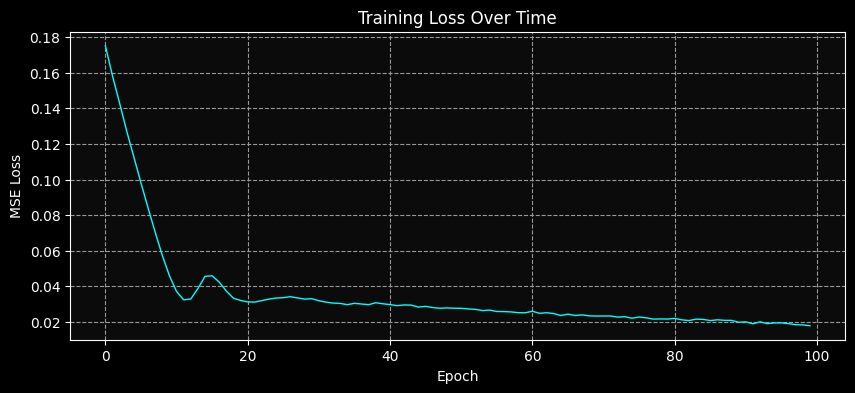

In [14]:
# Train the model
EPOCHS = 100
train_losses = []

print("Training LSTM on GPU...")
start_time = time.time()

model.train()
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")

train_time = time.time() - start_time
print(f"\nTraining complete in {train_time:.2f}s on {device}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, color='cyan')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

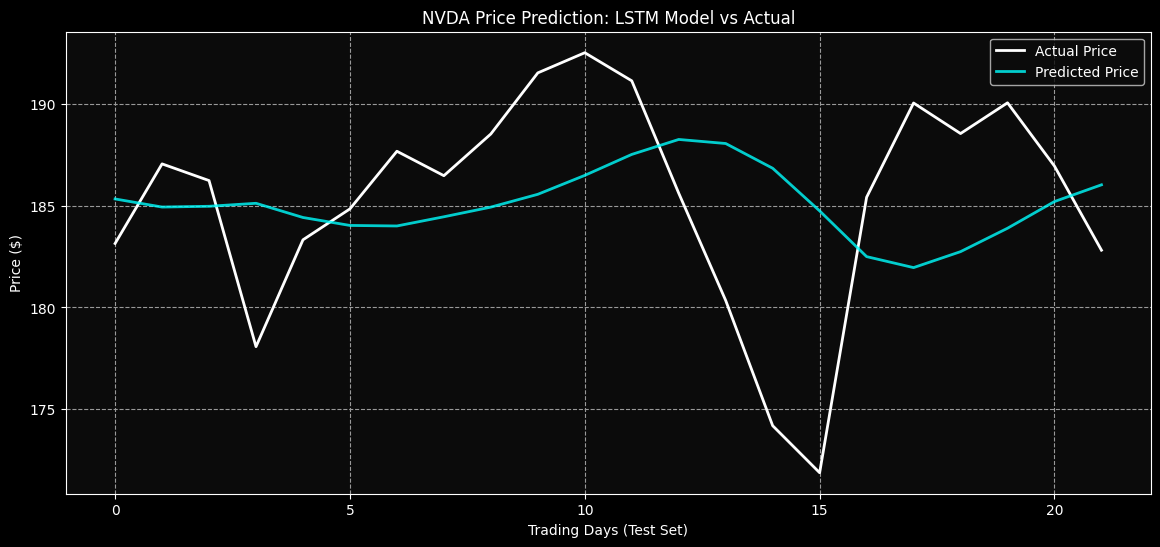

Mean Absolute Error: $4.69
Root Mean Squared Error: $5.75

Note: This simple model only uses price history.
Real models incorporate volume, indicators, sentiment, and more.


In [15]:
# Evaluate and visualize predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train_t).cpu().numpy()
    test_pred = model(X_test_t).cpu().numpy()

# Inverse transform to get actual prices
train_pred_prices = scaler.inverse_transform(train_pred)
test_pred_prices = scaler.inverse_transform(test_pred)
actual_prices = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(range(len(actual_prices)), actual_prices, label='Actual Price', color='white', linewidth=2)
plt.plot(range(len(test_pred_prices)), test_pred_prices, label='Predicted Price', color='cyan', linewidth=2, alpha=0.8)
plt.title('NVDA Price Prediction: LSTM Model vs Actual')
plt.xlabel('Trading Days (Test Set)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Calculate simple accuracy metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(actual_prices, test_pred_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, test_pred_prices))
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")
print(f"\nNote: This simple model only uses price history.")
print(f"Real models incorporate volume, indicators, sentiment, and more.")

---
## 7. HuggingFace Models for Finance

Your RTX 4090 with 24GB VRAM can run a wide range of models locally.
Here's a curated list of HuggingFace models relevant to day trading:

### Sentiment Analysis Models

| Model | Size | Description |
|-------|------|-------------|
| **ProsusAI/finbert** | ~500MB | BERT fine-tuned on financial news. Classifies positive/negative/neutral. The gold standard for financial sentiment. |
| **mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis** | ~300MB | Smaller, faster alternative to FinBERT. Good for real-time analysis. |
| **cardiffnlp/twitter-roberta-base-sentiment-latest** | ~500MB | Great for analyzing Twitter/X sentiment about stocks. |
| **yiyanghkust/finbert-tone** | ~500MB | Classifies financial text tone: positive/negative/neutral with nuance. |

### Text Generation / Analysis

| Model | Size | Description |
|-------|------|-------------|
| **microsoft/phi-3-mini-4k-instruct** | ~7GB | Small but capable LLM. Can analyze financial reports, summarize news. |
| **meta-llama/Llama-3.2-3B-Instruct** | ~6GB | Excellent for financial text analysis. Fits comfortably on your 4090. |
| **mistralai/Mistral-7B-Instruct-v0.3** | ~14GB | Powerful general model. Can reason about market conditions. |
| **TheBloke/Llama-2-13B-chat-GPTQ** | ~7GB | Quantized 13B model. Great balance of capability and speed. |

### Time Series / Forecasting

| Model | Size | Description |
|-------|------|-------------|
| **amazon/chronos-t5-large** | ~1.5GB | Purpose-built time series forecasting model from Amazon. |
| **google/timesfm-1.0-200m** | ~800MB | Google's foundation model for time series forecasting. |
| **huggingface/autoformer** | varies | Transformer architecture designed for time series decomposition. |

### Named Entity Recognition (NER)

| Model | Size | Description |
|-------|------|-------------|
| **dslim/bert-base-NER** | ~400MB | Extract company names, ticker symbols from news text. |
| **Jean-Baptiste/camembert-ner-with-dates** | ~400MB | Extract dates and entities -- useful for earnings/event tracking. |

### What Your 4090 Can Handle

With **24GB VRAM**, you can run:
- Any model up to ~13B parameters (quantized)
- Any model up to ~7B parameters (full precision fp16)
- Multiple small models simultaneously (e.g., sentiment + NER pipeline)
- Fine-tune models up to ~7B parameters with QLoRA

In [16]:
# Example: Using Chronos for time series forecasting (if you want to try it)
# Uncomment and run -- this will download the model (~1.5GB first time)

# !pip install chronos-forecasting
# from chronos import ChronosPipeline
# 
# chronos = ChronosPipeline.from_pretrained(
#     "amazon/chronos-t5-large",
#     device_map="auto",
#     torch_dtype=torch.float16,
# )
# 
# # Forecast next 5 trading days for NVDA
# context = torch.tensor(nvda['Close'].values, dtype=torch.float32)
# forecast = chronos.predict(context, prediction_length=5)
# print("Chronos 5-day forecast:", forecast.median(dim=1).numpy())

print("Chronos example is commented out to avoid a large download.")
print("Uncomment the code above to try GPU-accelerated time series forecasting!")

Chronos example is commented out to avoid a large download.
Uncomment the code above to try GPU-accelerated time series forecasting!


---
## 8. GPU Acceleration Roadmap - Making the Most of Your RTX 4090

Your RTX 4090 is one of the most powerful consumer GPUs available. Here's how it
accelerates every aspect of a trading workflow:

### Speed Advantages

| Task | CPU Time | 4090 GPU Time | Speedup |
|------|----------|---------------|--------|
| Sentiment analysis (1000 headlines) | ~60s | ~2s | **30x** |
| LSTM training (100 epochs) | ~30s | ~2s | **15x** |
| Transformer inference (7B model) | ~10s/token | ~0.05s/token | **200x** |
| Backtesting 1000 strategies | ~hours | ~minutes | **10-50x** |
| Real-time indicator calculation | limited | thousands/sec | **massive** |

### What You Can Build

#### Phase 1: Data & Analysis (You're here now)
- Fetch and visualize market data
- Calculate technical indicators
- Understand chart patterns
- Paper trade (simulated trading)

#### Phase 2: Sentiment Pipeline
- Set up news feed scraping (newsapi.org, RSS feeds)
- Run FinBERT on incoming headlines in real-time
- Aggregate sentiment scores per stock
- Correlate sentiment changes with price moves

#### Phase 3: ML Signal Generation
- Train LSTM/Transformer models on price + volume + indicators
- Use Chronos or TimesFM for probabilistic forecasting
- Build ensemble models combining multiple signals
- Backtest strategies on historical data

#### Phase 4: Advanced GPU Workflows
- Run a local LLM (Llama 3, Mistral) to analyze SEC filings and earnings calls
- Fine-tune FinBERT on your own labeled data with QLoRA
- Reinforcement learning for trade execution
- Real-time inference pipeline processing multiple data streams

### Key Libraries for GPU Trading

| Library | Purpose |
|---------|--------|
| **PyTorch** | Deep learning framework (what we used above) |
| **RAPIDS cuDF** | GPU-accelerated pandas -- process millions of rows instantly |
| **RAPIDS cuML** | GPU-accelerated scikit-learn |
| **Transformers** | Run HuggingFace models on GPU |
| **vLLM** | High-throughput LLM inference server |
| **Backtrader/Zipline** | Strategy backtesting frameworks |
| **Alpaca/IBKR API** | Live trading APIs (when you're ready) |

---
## 9. Risk Management - THE Most Important Topic

**This section matters more than everything above combined.**

The #1 reason day traders fail is poor risk management, not bad analysis.

### The Hard Truth About Day Trading
- Studies show **70-90% of day traders lose money**
- The average day trader underperforms a simple S&P 500 buy-and-hold strategy
- Successful traders typically spend 6-12 months learning before becoming profitable
- **Never trade with money you can't afford to lose**

### Core Risk Management Rules

1. **The 1% Rule**: Never risk more than 1% of your total account on a single trade
   - $25,000 account = max $250 risk per trade
   
2. **Always Use Stop Losses**: Define your exit BEFORE entering a trade
   - Calculate position size based on stop loss distance
   
3. **Risk/Reward Ratio**: Only take trades with at least 2:1 reward-to-risk
   - If risking $100, target at least $200 profit
   
4. **Daily Loss Limit**: Stop trading after losing 3% of account in a day

5. **Paper Trade First**: Practice with simulated money for at least 3 months

In [17]:
# Position Size Calculator
# This is one of the most important tools for a day trader

def calculate_position_size(account_size, risk_percent, entry_price, stop_loss_price):
    """Calculate how many shares to buy based on risk management rules."""
    risk_amount = account_size * (risk_percent / 100)
    risk_per_share = abs(entry_price - stop_loss_price)
    
    if risk_per_share == 0:
        return 0, 0
    
    shares = int(risk_amount / risk_per_share)
    position_value = shares * entry_price
    
    return shares, position_value

# Example scenarios
print("=== Position Size Calculator ===")
print()

scenarios = [
    (25000, 1.0, 150.00, 148.50),  # NVDA example
    (25000, 1.0, 450.00, 445.00),  # High-price stock
    (25000, 1.0, 15.00, 14.50),    # Low-price stock
    (50000, 0.5, 150.00, 148.00),  # Larger account, tighter risk
]

for account, risk_pct, entry, stop in scenarios:
    shares, value = calculate_position_size(account, risk_pct, entry, stop)
    risk_dollars = account * (risk_pct / 100)
    print(f"Account: ${account:>8,} | Risk: {risk_pct}% (${risk_dollars:>6,.0f}) | "
          f"Entry: ${entry:>7.2f} | Stop: ${stop:>7.2f} | "
          f"Shares: {shares:>4} | Position: ${value:>10,.2f}")

print("\n--- Key Takeaway ---")
print("Position size is determined by your RISK, not your conviction.")
print("The stop loss distance determines how many shares you can safely trade.")

=== Position Size Calculator ===

Account: $  25,000 | Risk: 1.0% ($   250) | Entry: $ 150.00 | Stop: $ 148.50 | Shares:  166 | Position: $ 24,900.00
Account: $  25,000 | Risk: 1.0% ($   250) | Entry: $ 450.00 | Stop: $ 445.00 | Shares:   50 | Position: $ 22,500.00
Account: $  25,000 | Risk: 1.0% ($   250) | Entry: $  15.00 | Stop: $  14.50 | Shares:  500 | Position: $  7,500.00
Account: $  50,000 | Risk: 0.5% ($   250) | Entry: $ 150.00 | Stop: $ 148.00 | Shares:  125 | Position: $ 18,750.00

--- Key Takeaway ---
Position size is determined by your RISK, not your conviction.
The stop loss distance determines how many shares you can safely trade.


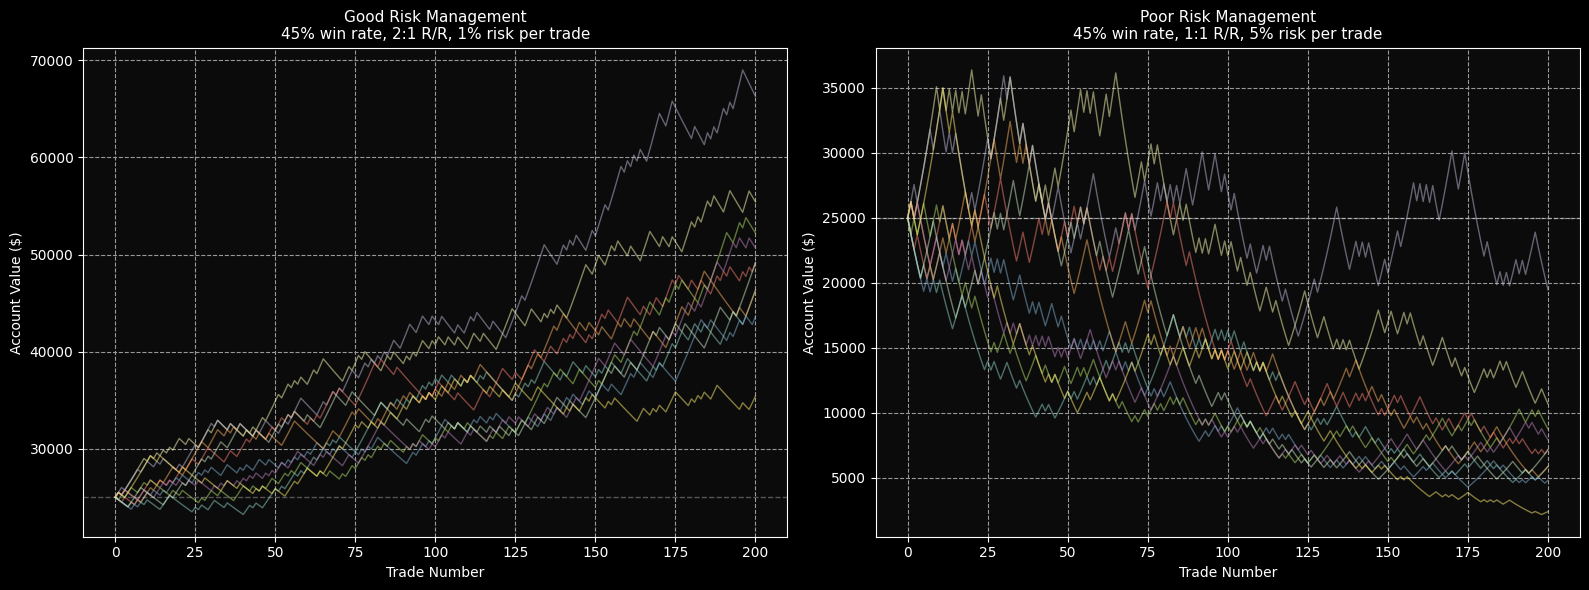

Left: Even with only 45% win rate, good R/R ratio + small risk = growth
Right: Equal wins and losses + large risk = almost certain ruin

The EDGE in trading comes from risk management, not prediction accuracy.


In [18]:
# Simulate the impact of risk management on a trading account
np.random.seed(42)

def simulate_trading(n_trades, win_rate, avg_win, avg_loss, starting_capital, risk_pct):
    """Simulate a series of trades with given parameters."""
    capital = starting_capital
    equity_curve = [capital]
    
    for _ in range(n_trades):
        risk_amount = capital * (risk_pct / 100)
        
        if np.random.random() < win_rate:
            # Winner
            capital += risk_amount * avg_win
        else:
            # Loser
            capital -= risk_amount * avg_loss
        
        equity_curve.append(max(capital, 0))  # Can't go below 0
        if capital <= 0:
            break
    
    return equity_curve

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scenario 1: Good risk management
for i in range(10):
    np.random.seed(i)
    curve = simulate_trading(
        n_trades=200, win_rate=0.45, avg_win=2.0, avg_loss=1.0,
        starting_capital=25000, risk_pct=1.0
    )
    axes[0].plot(curve, alpha=0.5, linewidth=1)

axes[0].axhline(y=25000, color='white', linestyle='--', alpha=0.3)
axes[0].set_title('Good Risk Management\n45% win rate, 2:1 R/R, 1% risk per trade', fontsize=11)
axes[0].set_xlabel('Trade Number')
axes[0].set_ylabel('Account Value ($)')

# Scenario 2: Poor risk management
for i in range(10):
    np.random.seed(i)
    curve = simulate_trading(
        n_trades=200, win_rate=0.45, avg_win=1.0, avg_loss=1.0,
        starting_capital=25000, risk_pct=5.0
    )
    axes[1].plot(curve, alpha=0.5, linewidth=1)

axes[1].axhline(y=25000, color='white', linestyle='--', alpha=0.3)
axes[1].set_title('Poor Risk Management\n45% win rate, 1:1 R/R, 5% risk per trade', fontsize=11)
axes[1].set_xlabel('Trade Number')
axes[1].set_ylabel('Account Value ($)')

plt.tight_layout()
plt.show()

print("Left: Even with only 45% win rate, good R/R ratio + small risk = growth")
print("Right: Equal wins and losses + large risk = almost certain ruin")
print("\nThe EDGE in trading comes from risk management, not prediction accuracy.")

---
## 10. Next Steps & Resources

### Immediate Next Steps (This Week)

1. **Paper Trade**: Open a paper trading account (Webull, ThinkorSwim, or Alpaca)
2. **Watch the Market**: Spend time just watching charts during market hours
3. **Learn 1 Strategy**: Pick ONE strategy (e.g., VWAP bounce) and study it deeply
4. **Journal Everything**: Record every trade idea and outcome

### Building Your AI Trading System (Coming Weeks)

1. **Data Pipeline**: Set up automated data collection (price, news, social media)
2. **Sentiment Dashboard**: Real-time FinBERT analysis of news feeds
3. **Backtesting Engine**: Test strategies on historical data before risking real money
4. **Signal Generator**: Combine technical indicators + ML + sentiment into trade signals
5. **Paper Trading Bot**: Automate your strategy in paper trading mode

### Free Data Sources

| Source | Data Type | Notes |
|--------|-----------|-------|
| **Yahoo Finance (yfinance)** | Historical OHLCV | Free, delayed. Good for learning |
| **Alpha Vantage** | OHLCV + fundamentals | Free tier: 25 API calls/day |
| **Polygon.io** | Real-time + historical | Free tier available, paid for real-time |
| **Alpaca Markets** | Real-time + trading API | Free paper trading with real-time data |
| **FRED** | Economic data | Federal Reserve economic data |
| **SEC EDGAR** | Company filings | Earnings reports, insider trading, 10-K/10-Q |

### Recommended Learning Path

1. **Books**: "Trading in the Zone" by Mark Douglas (psychology), "Technical Analysis of the Financial Markets" by John Murphy
2. **Concepts**: Support/resistance, supply/demand, market structure, order flow
3. **Practice**: 3+ months of paper trading before using real money
4. **Community**: r/daytrading, r/algotrading on Reddit for discussion

### Important Legal/Financial Notes

- **PDT Rule**: US requires $25,000 minimum to make 4+ day trades in 5 business days
- **Taxes**: Day trading profits are taxed as short-term capital gains (your income tax rate)
- **This is not financial advice**: This notebook is for educational purposes only
- **Start small**: If/when you trade real money, start with small positions

---

### Notebook Project Ideas to Build Next

| Notebook | Description |
|----------|-------------|
| `02_Sentiment_Pipeline.ipynb` | Real-time news sentiment with FinBERT on GPU |
| `03_Technical_Strategy.ipynb` | Build and backtest a complete trading strategy |
| `04_Chronos_Forecasting.ipynb` | Time series forecasting with Amazon Chronos |
| `05_LLM_Analysis.ipynb` | Use a local LLM to analyze earnings calls |
| `06_Backtesting_Engine.ipynb` | Systematic strategy backtesting framework |
| `07_Paper_Trading_Bot.ipynb` | Automated paper trading with Alpaca API |

In [19]:
# Environment summary
print("=" * 60)
print("   DAY TRADING ENVIRONMENT SUMMARY")
print("=" * 60)
print(f"\n  Python:       {pd.__version__} (via pandas)")
print(f"  PyTorch:      {torch.__version__}")
print(f"  CUDA:         {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU:          {torch.cuda.get_device_name(0)}")
    print(f"  VRAM:         {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"  Transformers: loaded")
print(f"\n  Key Packages Installed:")
print(f"    - yfinance (market data)")
print(f"    - ta (technical indicators)")
print(f"    - mplfinance (candlestick charts)")
print(f"    - scikit-learn (ML)")
print(f"    - transformers (HuggingFace models)")
print(f"    - torch + CUDA (GPU acceleration)")
print(f"\n  Kernel: 'daytrader' (Python 3.10)")
print(f"\n  You're ready to explore day trading with AI!")
print("=" * 60)

   DAY TRADING ENVIRONMENT SUMMARY

  Python:       2.3.3 (via pandas)
  PyTorch:      2.6.0+cu124
  CUDA:         True
  GPU:          NVIDIA GeForce RTX 4090
  VRAM:         23.5 GB
  Transformers: loaded

  Key Packages Installed:
    - yfinance (market data)
    - ta (technical indicators)
    - mplfinance (candlestick charts)
    - scikit-learn (ML)
    - transformers (HuggingFace models)
    - torch + CUDA (GPU acceleration)

  Kernel: 'daytrader' (Python 3.10)

  You're ready to explore day trading with AI!


In [20]:
!nvidia-smi

Fri Feb 13 18:06:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
|  0%   37C    P2             87W /  450W |    1018MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----